##### LSTM Network - Prediction (model training)

The example below will build the LSTM model on the FTSE 100 up to today (2025-12-23) and split the training/validation. Then the prediction module will look ahead 300 days and try to make a  prediction based on a random generation. 

In [2]:
%%capture
%pip install -r requirements.txt

In [3]:
# Copyright 2020-2026 Jordi Corbilla. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import os
import warnings
import secrets
import pandas as pd
import argparse
import numpy as np
import pickle

from stock_prediction_class import StockPrediction
from stock_prediction_lstm import LongShortTermMemory
from stock_prediction_numpy import StockData
from stock_prediction_plotter import Plotter
from stock_prediction_readme_generator import ReadmeGenerator
from stock_prediction_deep_learning import train_LSTM_network

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or '3' to suppress all messages

# Suppress other warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
warnings.filterwarnings("ignore", message=".*np.object.*", category=FutureWarning)

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from pandas.tseries.offsets import BDay

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Ticker: GOOG
Start Date: 2017-01-01
Validation Date: 2017-01-01
Test Run Folder: GOOG_20251228_30544a534e8264a90863b89a3b8cd7ff
End Date: 2025-12-28
mean: [0.40941686]
max 1.0
min 0.0
Std dev: [0.29777125]
plotting Data and Histogram


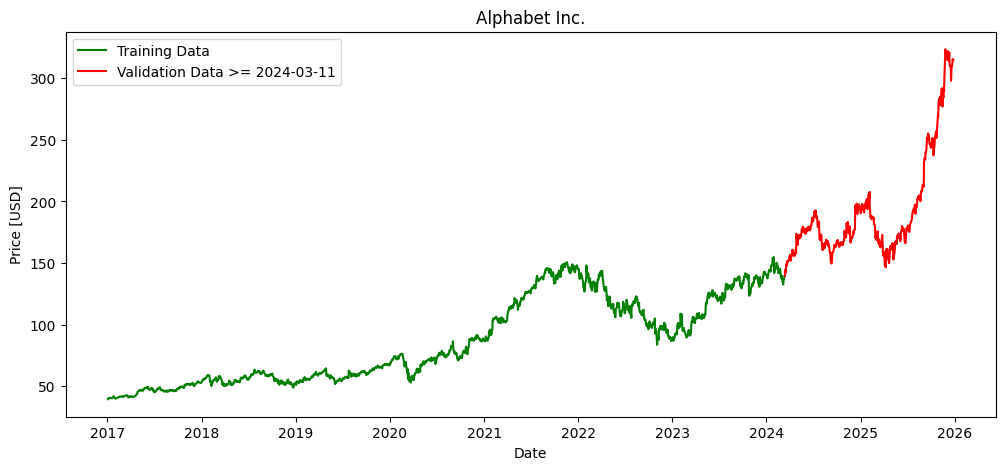

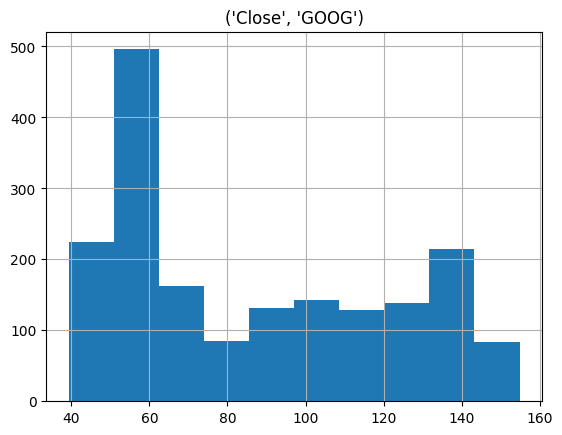

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - MSE: 0.0085 - loss: 0.0043 - val_MSE: 0.0245 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - MSE: 0.0030 - loss: 0.0015 - val_MSE: 0.0371 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - MSE: 0.0026 - loss: 0.0013 - val_MSE: 0.0368 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - MSE: 0.0024 - loss: 0.0012 - val_MSE: 0.0143 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - MSE: 0.0021 - loss: 0.0011 - val_MSE: 0.0124 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - MSE: 0.0023 - loss: 0.0011 - val_MSE: 0.0102 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - MSE: 0.0019 - loss: 9.5046e-04 - val_MSE: 0.0131 - val_loss: 0.0065 - learning_

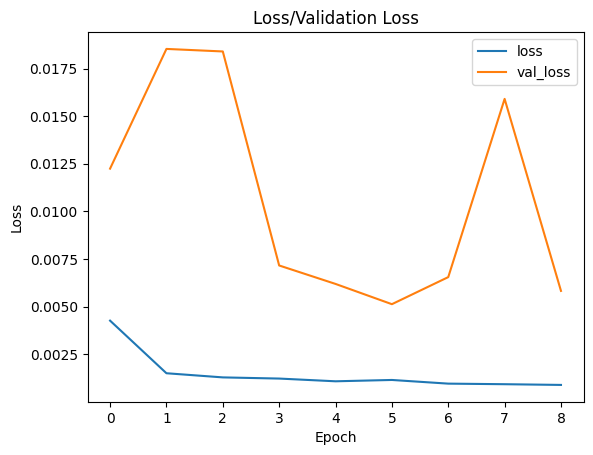

plotting MSE


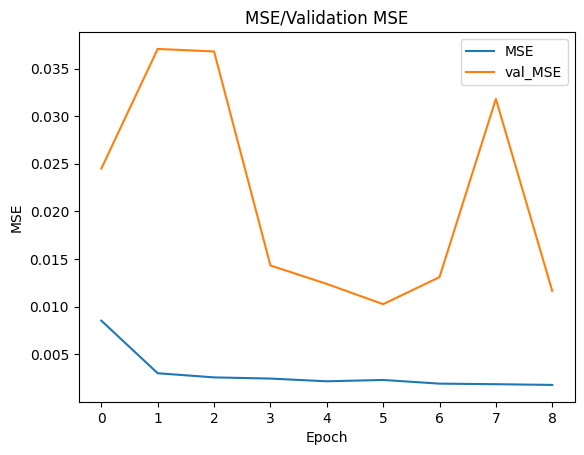

display the content of the model
15/15 - 0s - 24ms/step - MSE: 0.0116 - loss: 0.0058
loss :  0.005822047125548124
compile_metrics :  0.011644094251096249

plotting prediction results
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
plotting predictions


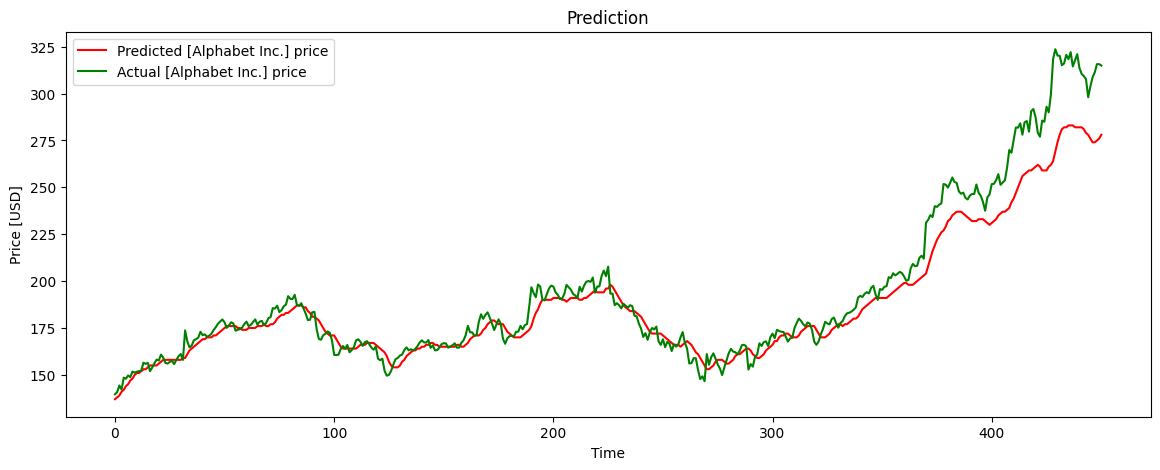

prediction is finished


In [4]:
STOCK_TICKER = "GOOG"
STOCK_START_DATE = pd.to_datetime('2017-01-01')
end_date = datetime.today()
duration = end_date - STOCK_START_DATE
STOCK_VALIDATION_DATE = STOCK_START_DATE + 0.8 * duration
EPOCHS = 100
BATCH_SIZE = 10
TIME_STEPS = 60
USE_RETURNS = False
CLIP_NEGATIVE = True
TODAY_RUN = datetime.today().strftime("%Y%m%d")
TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)
GITHUB_URL = "https://github.com/JordiCorbilla/stock-prediction-deep-neural-learning/raw/master/"
print('Ticker: ' + STOCK_TICKER)
print('Start Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
print('Validation Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
print('Test Run Folder: ' + TOKEN)
# create project run folder
PROJECT_FOLDER = os.path.join(os.getcwd(), TOKEN)
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)

stock_prediction = StockPrediction(STOCK_TICKER, 
                                   STOCK_START_DATE, 
                                   STOCK_VALIDATION_DATE, 
                                   PROJECT_FOLDER, 
                                   GITHUB_URL,
                                   EPOCHS,
                                   TIME_STEPS,
                                   TOKEN,
                                   BATCH_SIZE)
# Execute Deep Learning model
train_LSTM_network(stock_prediction, USE_RETURNS, model_version='v4')

## Infer the Future Data (Predictions)

2.18.1
Latest Stock Price
314.9599914550781
Latest Date
2025-12-26 00:00:00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 348,101 (1.33 MB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,068 (906.52 KB)

Sanity check - next day delta: -11.50%


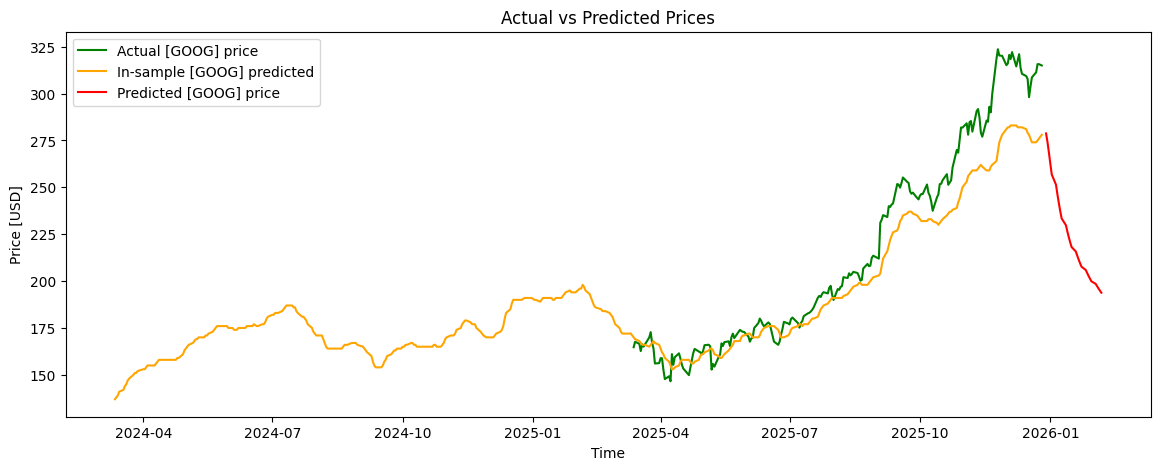

In [6]:
def _load_scaler(inference_folder):
    scaler_path = os.path.join(inference_folder, 'min_max_scaler.pkl')
    if not os.path.exists(scaler_path):
        return None
    with open(scaler_path, 'rb') as scaler_file:
        return pickle.load(scaler_file)


def _load_input_scaler(inference_folder):
    scaler_path = os.path.join(inference_folder, 'input_scaler.pkl')
    if not os.path.exists(scaler_path):
        return None
    with open(scaler_path, 'rb') as scaler_file:
        return pickle.load(scaler_file)


def _load_config(inference_folder):
    config_path = os.path.join(inference_folder, 'model_config.json')
    if not os.path.exists(config_path):
        return None
    with open(config_path, 'r', encoding='utf-8') as config_file:
        return json.load(config_file)


def _future_dates(last_date, forecast_days, use_business_days):
    if use_business_days:
        return pd.bdate_range(last_date + BDay(1), periods=forecast_days)
    return pd.date_range(last_date + timedelta(1), periods=forecast_days)


def _returns_to_prices(returns, start_price):
    prices = []
    current_price = start_price
    for value in returns:
        current_price = current_price * np.exp(value)
        prices.append(current_price)
    return prices


def _ensure_frame(series_or_frame):
    if isinstance(series_or_frame, pd.Series):
        return series_or_frame.to_frame()
    return series_or_frame


def _scale_input(scaler, data):
    if hasattr(scaler, 'feature_names_in_'):
        return scaler.transform(_ensure_frame(data))
    array_data = np.asarray(data)
    if array_data.ndim == 1:
        array_data = array_data.reshape(-1, 1)
    return scaler.transform(array_data)


def _get_close_series(raw_data):
    close_data = raw_data['Close']
    if isinstance(close_data, pd.DataFrame):
        close_data = close_data.iloc[:, 0]
    return close_data


def _load_in_sample_predictions(inference_folder, ticker):
    predictions_path = os.path.join(inference_folder, 'predictions.csv')
    if not os.path.exists(predictions_path):
        return None
    predictions = pd.read_csv(predictions_path, index_col=0, parse_dates=True)
    if predictions.empty:
        return None
    expected_col = ticker + '_predicted'
    if expected_col in predictions.columns:
        series = predictions[[expected_col]]
    else:
        series = predictions.iloc[:, [0]]
    series.index = pd.to_datetime(series.index, errors='coerce')
    series = series.dropna()
    return series


def infer_data():
    print(tf.version.VERSION)
    inference_folder = os.path.join(os.getcwd(), PROJECT_FOLDER)
    stock = StockPrediction(STOCK_TICKER, STOCK_START_DATE, STOCK_VALIDATION_DATE, inference_folder, GITHUB_URL, EPOCHS, TIME_STEPS, TOKEN, BATCH_SIZE)

    data = StockData(stock)
    raw_data = data.download_raw_data()
    if raw_data.empty:
        print("Error: No data available for inference.")
        return

    close_series = _get_close_series(raw_data)
    print('Latest Stock Price')
    latest_close_price = float(close_series.iloc[-1])
    latest_date = raw_data.index[-1]
    print(latest_close_price)
    print('Latest Date')
    print(latest_date)

    model_path = os.path.join(inference_folder, 'model.keras')
    if not os.path.exists(model_path):
        model_path = os.path.join(inference_folder, 'model_weights.h5')
    model = tf.keras.models.load_model(model_path)
    model.summary()
    model_time_steps = model.input_shape[1]
    if model_time_steps and model_time_steps != TIME_STEPS:
        print('Warning: TIME_STEPS does not match model input. Using model value: ' + str(model_time_steps))
        time_steps = model_time_steps
    else:
        time_steps = TIME_STEPS

    scaler = _load_scaler(inference_folder)
    input_scaler = _load_input_scaler(inference_folder)
    config = _load_config(inference_folder)
    use_returns = USE_RETURNS
    use_deltas = USE_DELTAS
    model_version = 'v1'
    if config is not None:
        use_returns = bool(config.get('use_returns', use_returns))
        use_deltas = bool(config.get('use_deltas', use_deltas))
        model_version = config.get('model_version', model_version)
        if use_returns != USE_RETURNS:
            print('Warning: USE_RETURNS overridden by model_config.json')

    if use_returns:
        series = np.log(close_series).diff().dropna().rename('Close')
        recent_window = series.tail(time_steps)
    else:
        recent_window = close_series.tail(time_steps).to_frame()

    if len(recent_window) < time_steps:
        print("Error: Not enough data to build the inference window.")
        return

    if use_deltas:
        if input_scaler is None:
            print('Warning: input_scaler.pkl not found. Fitting input scaler on full dataset for inference.')
            input_scaler = data.get_input_scaler()
            input_scaler.fit(close_series.to_frame())

    if scaler is None:
        print('Warning: min_max_scaler.pkl not found. Fitting scaler on full dataset for inference.')
        scaler = data.get_min_max()
        if use_returns:
            scaler.fit(series.to_frame())
        elif use_deltas:
            deltas = close_series.diff().dropna().rename('Close')
            scaler.fit(deltas.to_frame())
        else:
            scaler.fit(close_series.to_frame())

    if use_deltas:
        window_scaled = _scale_input(input_scaler, recent_window)
    else:
        window_scaled = _scale_input(scaler, recent_window)
    window_scaled = window_scaled.reshape(1, time_steps, 1)

    future_dates = _future_dates(latest_date, FORECAST_DAYS, USE_BUSINESS_DAYS)
    predictions = []
    current_close = latest_close_price

    for _ in range(len(future_dates)):
        pred_scaled = model.predict(window_scaled, verbose=0)[0][0]
        pred_value = scaler.inverse_transform([[pred_scaled]])[0][0]
        predictions.append(pred_value)
        if use_deltas:
            current_close = current_close + pred_value
            next_scaled = _scale_input(input_scaler, pd.DataFrame({'Close': [current_close]}))
            window_scaled = np.concatenate([window_scaled[:, 1:, :], next_scaled.reshape(1, 1, 1)], axis=1)
        else:
            window_scaled = np.concatenate([window_scaled[:, 1:, :], [[[pred_scaled]]]], axis=1)

    if use_returns:
        predicted_prices = _returns_to_prices(predictions, latest_close_price)
    elif use_deltas:
        predicted_prices = latest_close_price + np.cumsum(predictions)
    else:
        predicted_prices = predictions
        if CLIP_NEGATIVE:
            predicted_prices = np.maximum(predicted_prices, 0)

    forecast_df = pd.DataFrame(
        {
            'Date': future_dates,
            'Predicted_Price': predicted_prices,
            'Predicted_Return': predictions if use_returns else np.nan,
            'Predicted_Delta': predictions if use_deltas else np.nan,
        }
    ).set_index('Date')
    forecast_df.to_csv(os.path.join(inference_folder, 'future_predictions.csv'))

    if len(forecast_df) > 0:
        first_pred = float(forecast_df['Predicted_Price'].iloc[0])
        latest_price = float(latest_close_price)
        delta_pct = ((first_pred - latest_price) / latest_price) * 100
        print('Sanity check - next day delta: ' + f'{delta_pct:.2f}%')

    history = close_series.tail(PLOT_HISTORY_DAYS)
    in_sample = _load_in_sample_predictions(inference_folder, STOCK_TICKER)
    plt.figure(figsize=(14, 5))
    plt.plot(history.index, history, color='green', label='Actual [' + STOCK_TICKER + '] price')
    if in_sample is not None and not in_sample.empty:
        plt.plot(in_sample.index, in_sample.iloc[:, 0], color='orange', label='In-sample [' + STOCK_TICKER + '] predicted')
    plt.plot(forecast_df.index, forecast_df['Predicted_Price'], color='red', label='Predicted [' + STOCK_TICKER + '] price')
    plt.xlabel('Time')
    plt.ylabel('Price [USD]')
    plt.legend()
    plt.title('Actual vs Predicted Prices')
    plt.savefig(os.path.join(inference_folder, STOCK_TICKER + '_future_forecast.png'))
    plt.show()

start_date = pd.to_datetime('2017-01-01')
end_date = datetime.today()
duration = end_date - start_date
STOCK_VALIDATION_DATE = start_date + 0.8 * duration
FORECAST_DAYS = 30
USE_BUSINESS_DAYS = True
PLOT_HISTORY_DAYS = 200
USE_RETURNS = False
USE_DELTAS = True
infer_data()
